In [47]:
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
np.random.seed(6278)
tf.set_random_seed(6728)

In [48]:
# data 
df = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat',
                  names =['Frequency','Angle of attack','Chord length','Free-stream','thickness','level'])
df.describe()

,Frequency,Angle of attack,Chord length,Free-stream,thickness,level
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [49]:
df.head()

,Frequency,Angle of attack,Chord length,Free-stream,thickness,level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


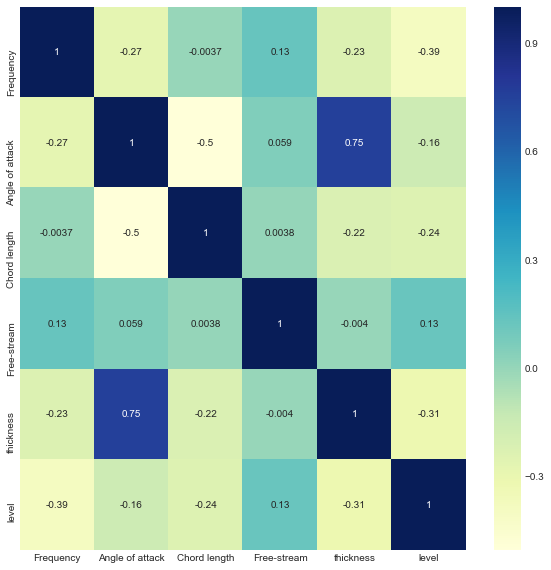

In [50]:
plt.figure( figsize=(10, 10))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu")

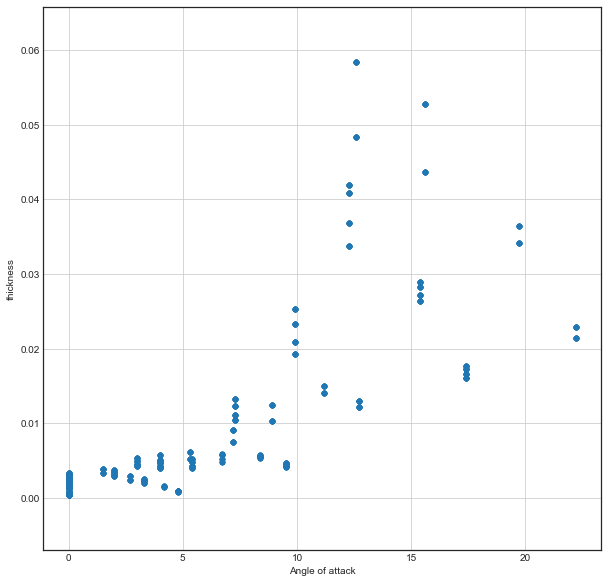

In [51]:
df.plot.scatter(x='Angle of attack', y='thickness',figsize=(10, 10),grid=True)

In [56]:
train_batch = np.expand_dims(df['Angle of attack'],1)
train_label = np.expand_dims(df['thickness'],1)
print(train_batch.shape)
print('--------')
print(train_label.shape)

(1503, 1)
--------
(1503, 1)


In [114]:
def tf_elu(x): return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float64) * x) + 1.0)
def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2
class FNN():
    
    def __init__(self,input_dim,hidden_dim,act,d_act):
        self.w = tf.Variable(tf.random_normal([input_dim,hidden_dim], stddev=0.05,seed=2,dtype=tf.float64))
        self.b = tf.Variable(tf.random_normal([], stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v_prev = tf.Variable(tf.zeros_like(self.w,dtype=tf.float64)),tf.Variable(tf.zeros_like(self.w,dtype=tf.float64))
        self.m_b,self.v_prev_b = tf.Variable(tf.zeros_like(self.b,dtype=tf.float64)),tf.Variable(tf.zeros_like(self.b,dtype=tf.float64))
        self.act,self.d_act = act,d_act

    def getw(self): return [self.w,self.b]

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w) + self.b
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient=None):
        grad_part_1 = gradient 
        grad_part_2 = self.d_act(self.layer) 
        grad_part_3 = self.input
        grad_part_4 = tf.ones_like(self.input)

        grad_middle = grad_part_1 * grad_part_2
        grad = tf.matmul(tf.transpose(grad_part_3),grad_middle)
        grad_b = tf.squeeze(tf.matmul(tf.transpose(grad_part_4),grad_middle))
        grad_pass = tf.matmul(tf.multiply(grad_part_1,grad_part_2),tf.transpose(self.w))

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v_prev,self.v_prev*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v_prev / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))    
        
        update_w.append(tf.assign( self.m_b,self.m_b*beta1 + (1-beta1) * (grad_b)   ))
        update_w.append(tf.assign( self.v_prev_b,self.v_prev_b*beta2 + (1-beta2) * (grad_b ** 2)   ))
        m_hat_b = self.m_b / (1-beta1)
        v_hat_b = self.v_prev_b / (1-beta2)
        adam_middel_b = learning_rate/(tf.sqrt(v_hat_b) + adam_e)
        update_w.append(tf.assign(self.b,tf.subtract(self.b,tf.multiply(adam_middel_b,m_hat_b)  )))    
        

        return grad_pass,update_w  

In [133]:
learning_rate = 0.001
batch_size = 1503
num_epoch = 600

beta1,beta2,adam_e = 0.9,0.999,1e-8

l1 = FNN(1,1,act=tf_tanh,d_act=d_tf_tanh)

x = tf.placeholder(shape=[None,1],dtype=tf.float64)
y = tf.placeholder(shape=[None,1],dtype=tf.float64)
layer1 = l1.feedforward(x)

cost = tf.reduce_mean(tf.square(layer1 - y) * 0.5)

# auto_train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
grad1,grad1_up = l1.backprop(layer1-y)

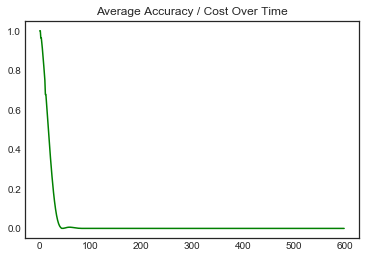

In [134]:
# sess
final_weights,final_bias = None,None
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    train_cota,train_acca = 0,0
    train_cot,train_acc = [],[]

    # start the training
    for iter in range(num_epoch):

        # train for batch
        for batch_size_index in range(0,len(train_batch),batch_size):
            current_batch = train_batch[batch_size_index:batch_size_index+batch_size]
            current_batch_label = train_label[batch_size_index:batch_size_index+batch_size]
            sess_result = sess.run([cost,grad1_up],feed_dict={x:current_batch,y:current_batch_label})
            print("Current Iter : ",iter ,' Current cost: ', sess_result[0],end='\r')
            train_cota = train_cota + sess_result[0]

        train_cot.append(train_cota/(len(train_batch)/(batch_size)))
        train_cota,train_acca = 0,0

    # Normalize the cost of the training
    train_cot = (train_cot-min(train_cot) ) / (max(train_cot)-min(train_cot))

    # plot the training and testing graph
    plt.figure()
    plt.plot(range(len(train_cot)),train_cot,color='green',label='Train cost ovt')
    plt.title("Average Accuracy / Cost Over Time")
    plt.show()
    
    #     
    (final_weights,final_bias) = sess.run(l1.getw())

Final Predict Equation = Ax + B
Final Predict Equation =  [[0.00162734]] x +  0.0003228323595903565


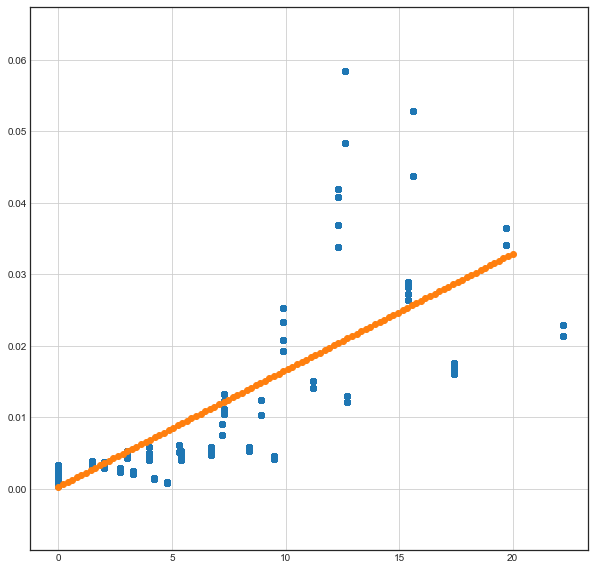

In [135]:
range_data = np.linspace(0.0, 20.0, num=100)
final_data = final_weights * range_data + final_bias
plt.figure(figsize=(10, 10))
plt.scatter(train_batch,train_label)
plt.scatter(range_data,final_data)
plt.grid()
print('Final Predict Equation = Ax + B')
print('Final Predict Equation = ',final_weights , "x + ",final_bias)